In [1]:
%matplotlib inline
!pip install geopandas

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import pandas as pd

In [13]:
import json

with open("disj_poly.json") as json_file:
    d = json.load(json_file)
df = gpd.read_file(json.dumps(d["result"]))

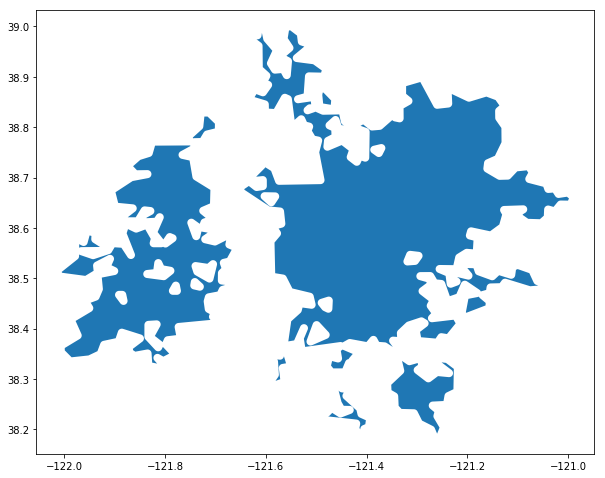

In [22]:
df.plot(figsize = (10, 10))

# Read the test road shape file and project it to metric system (World Mercator)

In [ ]:
test_roads = gpd.read_file('POIS/Test_Roads.shp')
#test_roads_pr = test_roads.to_crs({'init': 'epsg:3395'}) 


### plot the road geometry

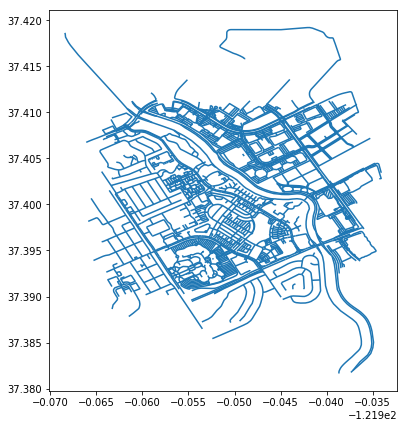

In [4]:
%matplotlib inline
test_roads.plot(figsize=(7,7))

In [5]:
test_roads.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,8927391,5122,residential,Transill Circle,None,B,0,0.0,F,F,"LINESTRING (-121.9477637 37.3956243, -121.9479..."
1,8928050,5141,service,Nantucket Circle,None,B,0,0.0,F,F,"LINESTRING (-121.9566015 37.4053879, -121.9567..."
2,8928052,5141,service,Nantucket Circle,None,B,0,0.0,F,F,"LINESTRING (-121.9573098 37.4057496, -121.9571..."
3,8928425,5122,residential,Nelson Court,None,B,0,0.0,F,F,"LINESTRING (-121.9568188 37.4000478, -121.9557..."
4,8929116,5115,tertiary,Baypointe Parkway,None,B,0,0.0,F,F,"LINESTRING (-121.9397444 37.4090322, -121.9402..."


<h3> 1.Get the COORDINATES of road geometry --> <b>"list_road_segments"</b></h3>
<h3> 2. Convert each pair of coordinates into ordered lists --> <b>"list_road_segment_pairs"</b></h4>

In [6]:
test_roads["geom_arr"] = \
test_roads["geometry"].apply(lambda geom : list(zip(*geom.xy)))

#test_roads_pr["list_road_segment_pairs"] = \
#test_roads_pr["list_road_segments"].apply(lambda x : [(x[p1], x[p1+1]) for p1 in range(len(x) - 1)])

# Explode the road segments into individual rows, such that we have one edge per row

In [7]:
def split_data_frame_list(df, 
                       target_column,
                          col_name,
                      output_type=list):
    ''' 
    Accepts a column with multiple types and splits list variables to several rows.

    df: dataframe to split
    target_column: the column containing the values to split
    output_type: type of all outputs
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    row_accumulator = []

    def split_list_to_rows(row):
        split_row = row[target_column]
        if isinstance(split_row, list):
            for s in split_row:
                new_row = row.to_dict()
                new_row[target_column] = output_type(s)
                row_accumulator.append(new_row)
        else:
            new_row = row.to_dict()
            new_row[target_column] = output_type(split_row)
            row_accumulator.append(new_row)
  
    df.apply(split_list_to_rows, axis=1)
    new_df = pd.DataFrame.from_records(row_accumulator, columns=[df.columns])
  
    return new_df

In [8]:
def return_src_dst(geom, src, dst):
    coords = list(zip(*geom.xy))
    node = {src : coords[0], dst : coords[1]}
    return gpd.GeoSeries(node)

# Find the length and walking time for each edge

<i>The average human walking speed at crosswalks is about 5.0 kilometres per hour (km/h), or about 1.4 meters per second (m/s), or about 3.1 miles per hour (mph).</i>
<h3>
$Time (s) = Distance (m)/Speed (m/s)$ <br/>
$Assuming man's walking speed = 5km/hr = 5 * 1000m/3600s$ <br/>
</h3>

In [10]:
#new_df = new_df.drop(columns=['geometry', 'list_road_segments'])
new_df = new_df.set_geometry("list_road_segment_pairs")
new_df[['src', 'dst']] = new_df.geometry.apply(lambda geom: return_src_dst(geom, "src", "dst"))
new_df["length"] = new_df.geometry.length
speed_in_kmph = 5
#speed_m_s = new_df["maxspeed"] if new_df["maxspeed"] else 100/9 #speed_in_kmph * 1000/3600
new_df["maxspeed"] = np.where(new_df["maxspeed"]==0, 100/9, new_df["maxspeed"])
new_df["drivetime_in_s"] = new_df["length"] / new_df["maxspeed"]

new_df.head()



roads_df["geometry_arr"] = roads_df["geometry"].apply(lambda geom :
list(zip(*geom.xy)))
roads_df["edge_list"] = roads_df["geometry_arr"].apply(lambda coords :
[[coords[i], coords[i+1]] for i in range(len(coords) - 1)])
edge_df = split_data_frame_list(roads_df, "edge_list", "geometry")
edge_df["source"] = edge_df["geometry"].apply(lambda edge: edge[0])
edge_df["target"] = edge_df["geometry"].apply(lambda edge: edge[1])
edge_df = edge_df.drop('geometry', axis = 1)
edge_df = edge_df.drop('geometry_arr', axis = 1)
roads_df = roads_df.drop(["geometry_arr", "edge_list"], axis = 1)
edge_df.head()

NameError: name 'new_df' is not defined

# All further analyses done using networkx library

In [ ]:
!pip install networkx

In [ ]:
import networkx as nx
from sklearn.neighbors import KDTree

# Create Graph from the GeoDataFrame

In [ ]:
G=nx.from_pandas_edgelist (df = new_df, source  = "src", target = "dst", \
                           edge_attr  = ['time_in_s', 'osm_id', 'fclass', 'name'], \
                           create_using  = nx.MultiGraph())


# Find Shortest Pathb/w two nodes

In [ ]:
%time
#Choose two nodes

node1 = (-13576189.646994088, 4469781.56574639)
node2 = (-13576468.947596489, 4468090.723281559)
sp = nx.shortest_path(G,source=node1,target=node2)

### Plot the Shortest Path

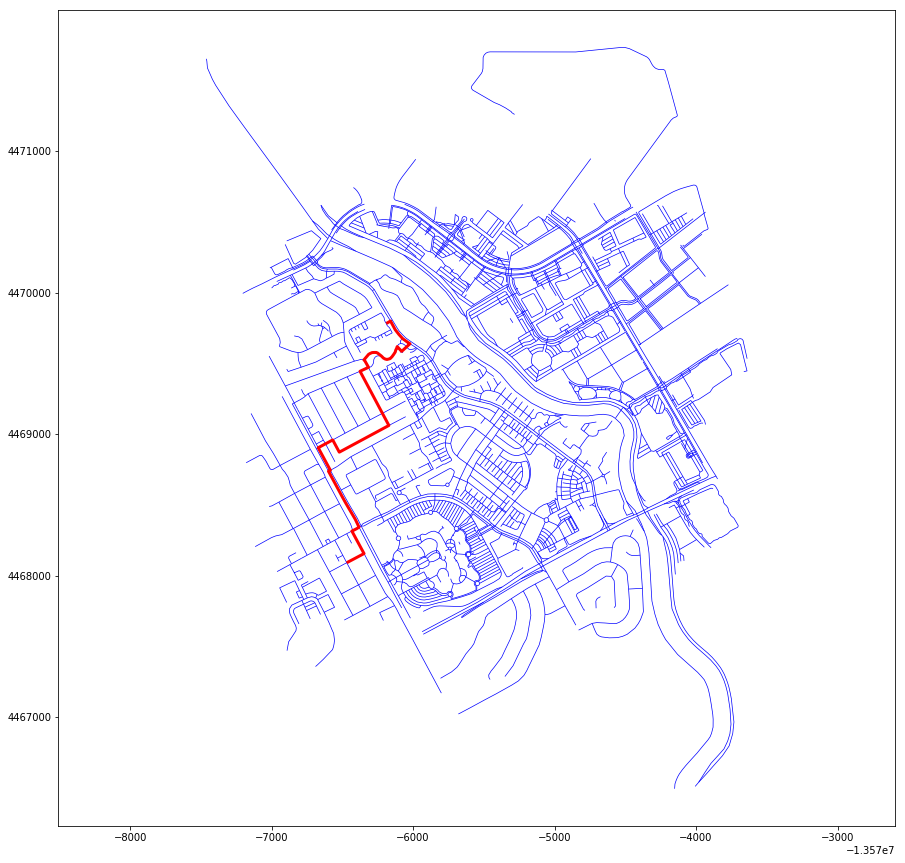

In [15]:
spd = gpd.GeoDataFrame({"geometry" : gpd.GeoSeries(LineString([(item) for item in sp]))})
f, ax = plt.subplots(1, figsize=(15,15))
ax = test_roads_pr.plot(color='blue', ax=ax, linewidth = 0.7)
lims = plt.axis('equal')
spd.plot(ax=ax, color='red', linewidth=3)

# Find Shortest path length to all nodes from a given node 
<h3>using time as weight

In [16]:
%time
spl = nx.shortest_path_length(G, source=node1, weight="time_in_s")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


### Display first 10 items in the Shortest path length Dictionary

<i> The keys of the dictionary are the node values and the values are time in seconds to reach the node from the source node</i>
<h3>{node: time in secoonds}</h3>

In [17]:
{k: spl[k] for k in list(spl)[:10]}

{(-13576189.646994088, 4469781.56574639): 0,
 (-13576182.633866169, 4469766.215916837): 12.150759561061324,
 (-13576201.97006172, 4469802.902047218): 17.74030512249562,
 (-13576159.423752338, 4469799.036670954): 25.134884928405015,
 (-13576166.804234577, 4469751.731280335): 27.599448598458284,
 (-13576204.71965314, 4469822.508039276): 31.9947628131414,
 (-13576164.332941882, 4469807.660508786): 32.2796187749031,
 (-13576146.777858185, 4469806.167384246): 35.587680945565445,
 (-13576158.856022935, 4469737.023394614): 39.636504351464126,
 (-13576147.623886313, 4469715.324417251): 57.22878037448936}

<h3>STEPS</h3>
<ul>
    <li>Filter all nodes within within a given time threshold</li>
    <li>Create a MultiPoint of all nodes </li>
    <li>From the Multipoint geometry Create a <B>BOUNDING POLYGON </B>arouund the points </li>
    <li>This polygon represents the walktime/drive-time polygon</li>
<ul>

In [18]:
from shapely.geometry import MultiPoint
from shapely.geometry import Point

points = MultiPoint([k for k, v in spl.items() if v <= 600])

## All nodes which can be reached within 10 mins walk from the given node

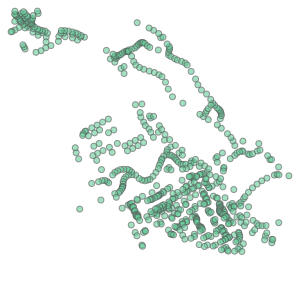

In [19]:
points

## Two approches to create BOUNDING polygon from points. 
<ol>
    <li>Create a <b>convex hull polygon</b> to cover the polygon - may not be the most accurate representation of the bounds</li>
    <li>Create a <b>buffer and reverse buffer</b> to fill up the holes and create a more accurate polygon</li>
</ol>
### 1. CONVEX HULL

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


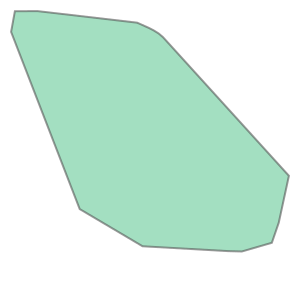

In [20]:
%time
points.convex_hull

### 2.BUFFER AND REVERSE BUFFER 

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


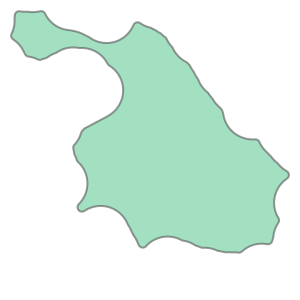

In [21]:
%time
points.buffer(150).buffer(-130)

In [22]:
polygon = points.buffer(150).buffer(-130) #points.convex_hull

### Plot the Walk-time polygon

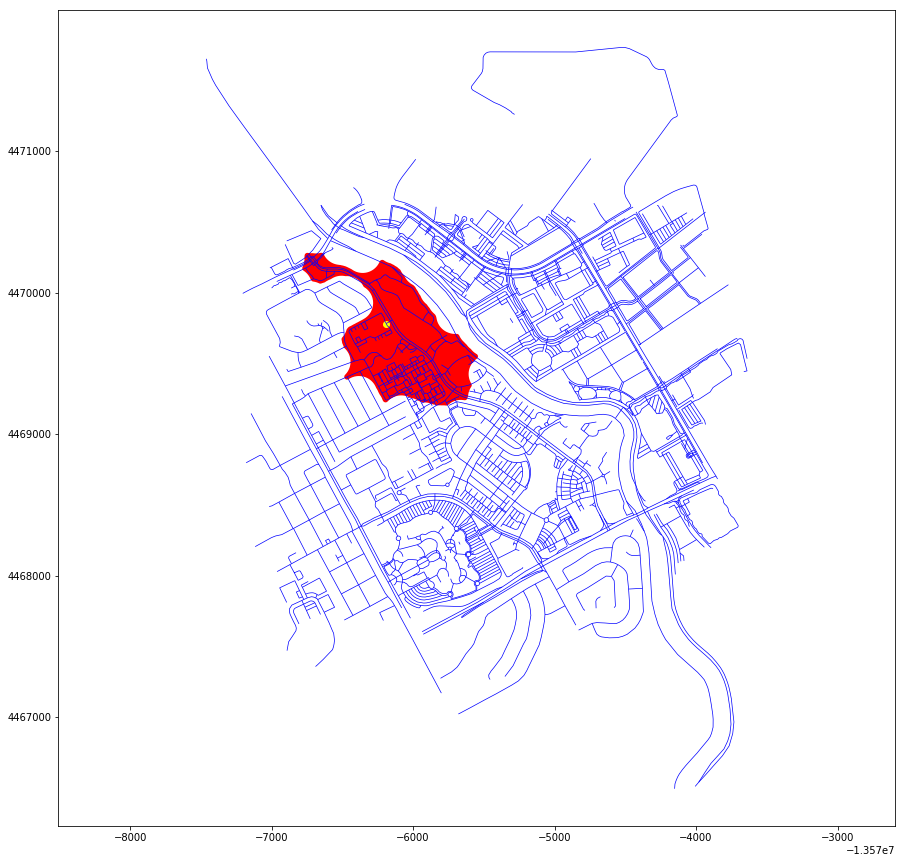

In [23]:
spd = gpd.GeoDataFrame({"geometry" : gpd.GeoSeries(polygon)})
f, ax = plt.subplots(1, figsize=(15,15))
ax = test_roads_pr.plot(color='blue', ax=ax, linewidth = 0.7)
lims = plt.axis('equal')
spd.plot(ax=ax, color='red')
point = gpd.GeoDataFrame({"geometry" : gpd.GeoSeries(Point(node1))})
point.plot(ax = ax, color = 'yellow')

In [12]:
import numpy as np
from math import radians, sin, cos, sqrt, asin

"""
DO NOT CHANGE THIS VALUE UNLESS THE RADIUS OF THE EARTH CHANGES !!!
"""

"""
Conversion Values
"""
RADIUS_OF_EARTH = 6371.0088 ##In kilometers; Change this to miles if you don't believe in metric system
KMS_TO_METERS = 1000.0
METERS_TO_KILOMETERS = 0.001
MILES_TO_KILOMETERS = 1.60934
KILOMETERS_TO_MILES = 0.621371


def gcd(loc1, loc2, R=RADIUS_OF_EARTH * KMS_TO_METERS):
    """Great circle distance via Haversine formula
    Parameters
    ----------
    loc1: tuple (long, lat in decimal degrees)
    loc2: tuple (long, lat in decimal degrees)
    R: Radius of the earth (3961 miles, 6367 km)
    Returns
    -------
    great circle distance between loc1 and loc2 in units of R
    Notes
    ------
    Does not take into account non-spheroidal shape of the Earth
    >>> san_diego = -117.1611, 32.7157
    >>> austin = -97.7431, 30.2672
    >>> gcd(san_diego, austin)
    1155.474644164695
    """
    lon1, lat1 = loc1
    lon2, lat2 = loc2
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))

    return R * c

In [13]:
loc1 = (-92.386059276497718,31.340669211981577)#	20524817132532326320	pleasanton	texas	27	42	
loc2 = (-98.48860063043481,28.982951315217395)
gcd(loc1, loc2)

642470.9105376381